# Timelag Analysis - Stainless Steel Experiment

This notebook plots downstream pressure data from stainless steel permeation runs, grouped by temperature.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from analysis_functions import *

In [2]:
# Load the CSV file with run information
csv_path = "results/figs/316l_steel_fresh_diffusivities.csv"
runs_df = pd.read_csv(csv_path)

print("Available runs:")
print(runs_df[['Run Name', 'Temperature (K)']])

# Group runs by temperature (round to nearest 50K for grouping)
runs_df['Temp_Group'] = (runs_df['Temperature (K)'] / 50).round() * 50

temp_groups = runs_df.groupby('Temp_Group')

print("\nTemperature groups:")
for temp, group in temp_groups:
    print(f"  {temp:.0f}K: {len(group)} runs")

Available runs:
            Run Name  Temperature (K)
0  11.19/run_1_12h32       750.071883
1  11.20/run_1_09h55       749.884183
2  11.21/run_1_08h42       750.345422
3  11.22/run_1_09h58       650.508529
4  11.23/run_1_20h27       651.002330
5  12.01/run_1_10h45       648.449376

Temperature groups:
  650K: 3 runs
  750K: 3 runs


In [3]:
# Results folder path
results_folder_path = "/Users/colinweaver/Documents/PTTEP/Results/"

# Load downstream pressure data for all runs
all_run_data = {}

for idx, row in runs_df.iterrows():
    run_name = row['Run Name']
    temp_group = row['Temp_Group']
    
    data_path = results_folder_path + run_name
    
    try:
        # Detect which file structure exists and load data accordingly
        if os.path.exists(data_path + "/shield_data.csv"):
            # Newest format: combined shield_data.csv
            t, df = load_downstream_data(data_path + "/shield_data.csv")
        elif os.path.exists(data_path + "/pressure_gauge_data.csv"):
            # Older formats: pressure_gauge_data.csv
            t, df = load_downstream_data(data_path + "/pressure_gauge_data.csv")
        else:
            raise FileNotFoundError(f"No recognized data file found in {data_path}")
        
        # Extract downstream pressure - try different column name formats
        try:
            V_Baratron_downstream = df["Baratron626D_1T_Voltage_V"].to_numpy(dtype=float)
        except KeyError:
            V_Baratron_downstream = df["Baratron626D_1T_Voltage (V)"].to_numpy(dtype=float)
        
        P_Baratron_downstream = voltage_to_torr_baratron_downstream(V_Baratron_downstream)
        
        all_run_data[run_name] = {
            'time': t,
            'pressure': P_Baratron_downstream,
            'temp_group': temp_group,
            'actual_temp': row['Temperature (K)']
        }
        
        print(f"Loaded: {run_name} ({row['Temperature (K)']:.1f}K)")
        
    except Exception as e:
        print(f"Could not load {run_name}: {e}")

print(f"\nSuccessfully loaded {len(all_run_data)} runs")

Loaded: 11.19/run_1_12h32 (750.1K)
Loaded: 11.20/run_1_09h55 (749.9K)
Loaded: 11.21/run_1_08h42 (750.3K)
Loaded: 11.22/run_1_09h58 (650.5K)
Loaded: 11.23/run_1_20h27 (651.0K)
Loaded: 12.01/run_1_10h45 (648.4K)

Successfully loaded 6 runs


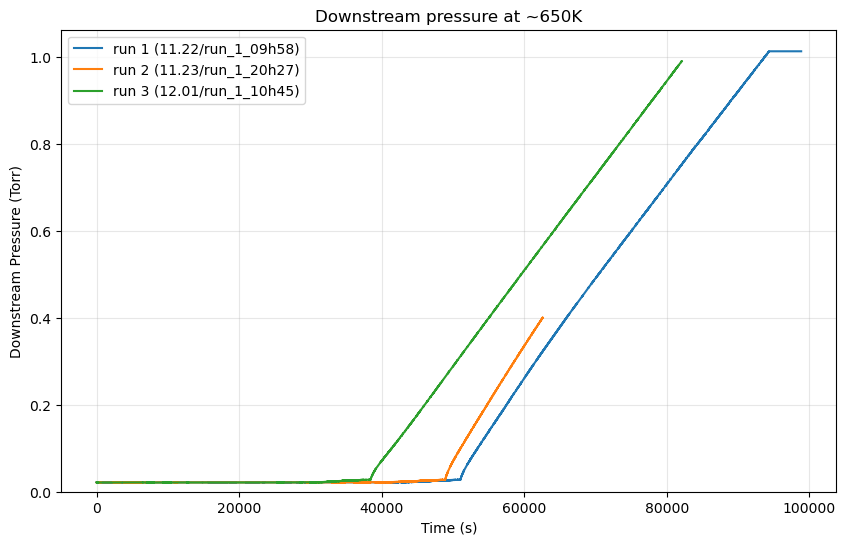

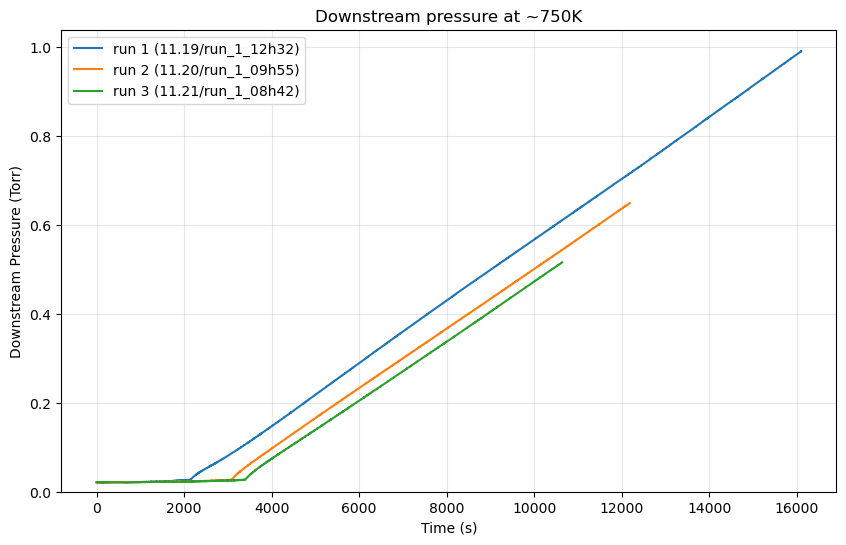

In [4]:
# Plot downstream pressure for each temperature group
# Similar to timelag_analysis.ipynb plotting style

# Group the loaded data by temperature
temp_grouped_data = {}
for run_name, data in all_run_data.items():
    temp_group = data['temp_group']
    if temp_group not in temp_grouped_data:
        temp_grouped_data[temp_group] = []
    temp_grouped_data[temp_group].append((run_name, data))

# Plot each temperature group
for temp_group in sorted(temp_grouped_data.keys()):
    runs = temp_grouped_data[temp_group]
    
    plt.figure(figsize=(10, 6))
    
    for i, (run_name, data) in enumerate(runs, start=1):
        t = data['time']
        P = data['pressure']
        actual_temp = data['actual_temp']
        
        # Shift time to start at zero (similar to timelag_analysis.ipynb)
        t_plot = t - t[0]
        
        plt.plot(t_plot, P, label=f"run {i} ({run_name})")
    
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Downstream Pressure (Torr)")
    plt.title(f"Downstream pressure at ~{temp_group:.0f}K")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


650K:
  Max pressure (run 1): 1.012e+00 Torr
  Threshold (5.0%): 5.060e-02 Torr


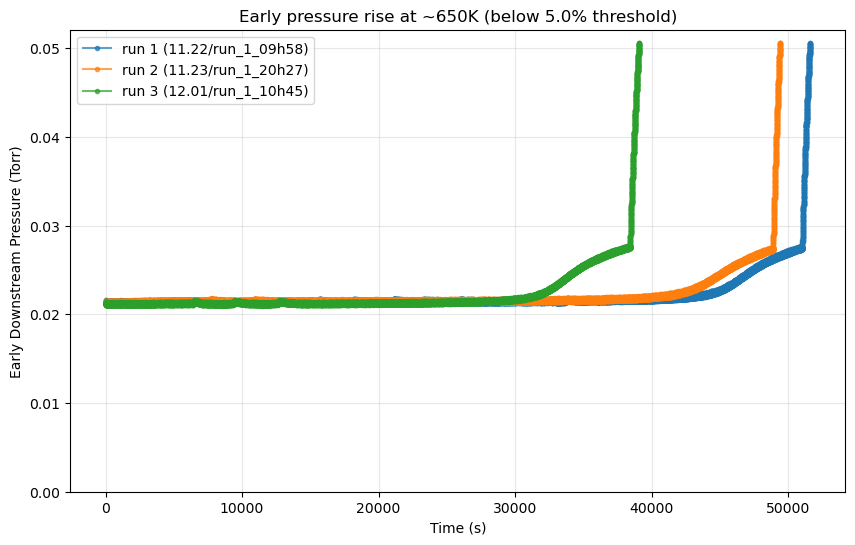


750K:
  Max pressure (run 1): 9.894e-01 Torr
  Threshold (5.0%): 4.947e-02 Torr


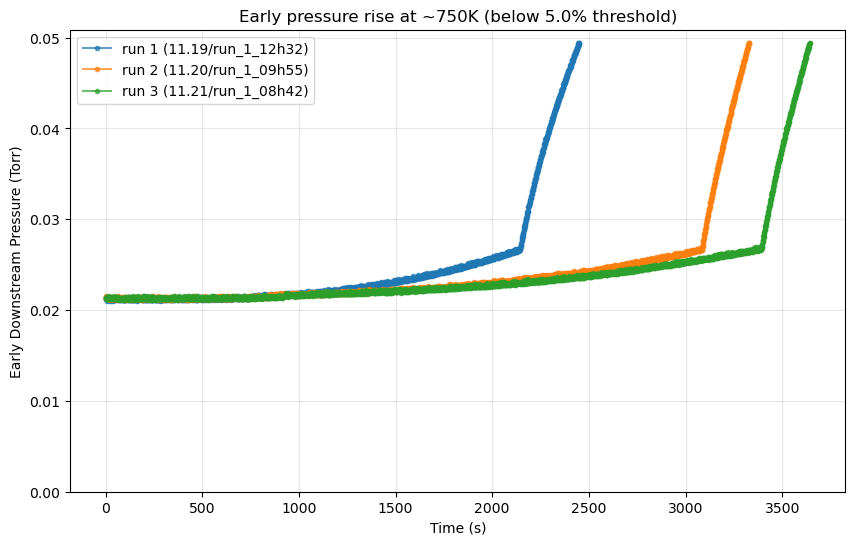

In [5]:
# Plot early portion of downstream pressure (similar to 5% threshold analysis)
pct = 0.05  # 5% threshold

for temp_group in sorted(temp_grouped_data.keys()):
    runs = temp_grouped_data[temp_group]
    
    if len(runs) == 0:
        continue
    
    # Get max pressure from first run to set threshold
    first_run_name, first_run_data = runs[0]
    max_pressure_first = np.max(first_run_data['pressure'])
    threshold = pct * max_pressure_first
    
    print(f"\n{temp_group:.0f}K:")
    print(f"  Max pressure (run 1): {max_pressure_first:.3e} Torr")
    print(f"  Threshold ({pct*100:.1f}%): {threshold:.3e} Torr")
    
    plt.figure(figsize=(10, 6))
    
    for i, (run_name, data) in enumerate(runs, start=1):
        t = data['time']
        P = data['pressure']
        
        # Extract early portion below threshold
        mask = P <= threshold
        t_early = t[mask]
        P_early = P[mask]
        
        if len(t_early) == 0:
            continue
        
        # Shift time to start at zero
        t_plot = t_early - t_early[0]
        
        plt.plot(t_plot, P_early, label=f"run {i} ({run_name})", marker='o', markersize=3, alpha=0.7)
    
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Early Downstream Pressure (Torr)")
    plt.title(f"Early pressure rise at ~{temp_group:.0f}K (below {pct*100}% threshold)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()